<h2> Import Libraries </h2>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


import warnings
warnings.simplefilter('ignore')

import tensorflow.keras as keras
from keras import Sequential

2022-05-05 18:18:46.837408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 18:18:46.837439: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Data

In [2]:
MFCC_PATH = 'pkl_files/mfcc.npy'
TARGET_PATH = 'pkl_files/target.csv'
SIGNAL_PATH = 'pkl_files/audio.npy'
MAPPING_FILE_PATH = 'pkl_files/mapping_file.npy'
MODEL1 = 'models/model1.h5'

In [4]:
X = np.load(MFCC_PATH, allow_pickle=True)
X = [X[i].reshape(44, 13) for i in range(len(X))]
X = np.array(X)
X = X.reshape(X.shape[0], 44, 13, 1)

In [10]:
y = pd.read_csv(TARGET_PATH, names=['target'])

In [11]:
# lable encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [12]:
mapping_file = np.array(le.classes_)
np.savetxt(MAPPING_FILE_PATH, mapping_file, fmt='%s')

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=101)

# Train Model`

In [14]:
def build_model(input_shape):
    model = Sequential()
    
    # features extracting layers
    # conv 1 + maxpool
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(keras.layers.BatchNormalization())
    
    # conv 2 + maxpool
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(keras.layers.BatchNormalization())
    
    # conv 3 + maxpool
    model.add(keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D((2, 1), strides=(2, 2), padding='valid'))
    model.add(keras.layers.BatchNormalization())
    
    # Flatten layer + classification layer
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(units=128, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.25))
    
    # Dense Layer
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(units=8, activation='softmax'))
    
    return model

In [15]:
model = build_model(X.shape[1:])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 5, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 20, 5, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 3, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 1, 32)         0         
 2D)                                                             
                                                        

2022-05-05 18:25:36.386356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 18:25:36.386957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 18:25:36.387038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-05 18:25:36.387111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-05 18:25:36.387182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [16]:
es = keras.callbacks.EarlyStopping(min_delta=0.01
                                   ,patience=20
                                   ,restore_best_weights=True)

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer
             ,loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val)
                    , epochs=10
                    , batch_size=32
                    , callbacks=[es])

Epoch 1/10
669/669 [==============================] - 12s 17ms/step - loss: 1.5456 - accuracy: 0.4296 - val_loss: 1.3385 - val_accuracy: 0.5114
Epoch 2/10
669/669 [==============================] - 11s 16ms/step - loss: 1.1941 - accuracy: 0.5898 - val_loss: 1.0786 - val_accuracy: 0.5983
Epoch 3/10
669/669 [==============================] - 11s 16ms/step - loss: 1.0426 - accuracy: 0.6487 - val_loss: 1.2654 - val_accuracy: 0.5824
Epoch 4/10
669/669 [==============================] - 11s 16ms/step - loss: 0.9409 - accuracy: 0.6858 - val_loss: 1.4442 - val_accuracy: 0.5353
Epoch 5/10
669/669 [==============================] - 11s 16ms/step - loss: 0.9014 - accuracy: 0.7017 - val_loss: 0.8643 - val_accuracy: 0.6947
Epoch 6/10
669/669 [==============================] - 12s 18ms/step - loss: 0.8583 - accuracy: 0.7191 - val_loss: 0.8455 - val_accuracy: 0.7165
Epoch 7/10
669/669 [==============================] - 14s 21ms/step - loss: 0.8512 - accuracy: 0.7200 - val_loss: 0.9103 - val_accuracy:

In [149]:
model.save(MODEL1)

In [19]:
model.evaluate(X_train, y_train)

669/669 [==============================] - 3s 4ms/step - loss: 0.8011 - accuracy: 0.7130


[0.8010547161102295, 0.7130235433578491]

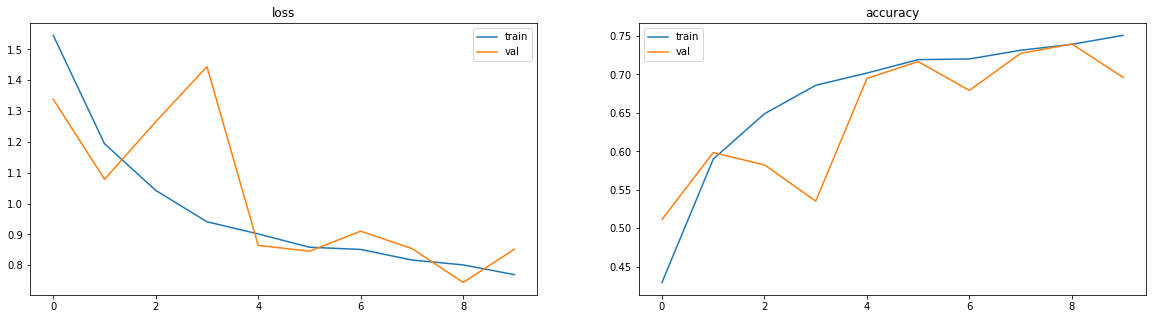

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(history.history['loss'], label='train')

axs[0].plot(history.history['val_loss'], label='val')
axs[0].set_title('loss')
axs[0].legend()
axs[1].plot(history.history['accuracy'], label='train')

axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].set_title('accuracy')
axs[1].legend()
plt.show()

# Evaluate Model Metrics

In [24]:
X = X.reshape(-1, 13, 44, 1)

In [25]:
rng = range(12000, 25000)
y_predict = model.predict(X[rng]).argmax(axis=1)
y_true = y[rng]

<AxesSubplot:>

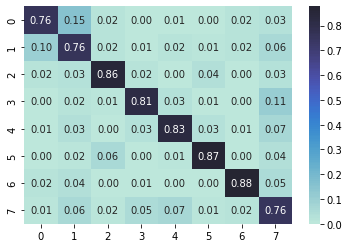

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_pred=y_predict, y_true=y_true)
cm = [cm[i, j] / sum(cm[i, :]) for i in range(8) for j in range(8)]
cm = np.array(cm).reshape(8, 8)


sns.heatmap(cm, annot=True, center=True, fmt='.2f')

In [27]:
print(classification_report(y_true, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1685
           1       0.68      0.76      0.71      1641
           2       0.86      0.86      0.86      1563
           3       0.87      0.81      0.84      1589
           4       0.85      0.83      0.84      1673
           5       0.90      0.87      0.88      1619
           6       0.93      0.88      0.90      1660
           7       0.66      0.76      0.71      1570

    accuracy                           0.82     13000
   macro avg       0.82      0.82      0.82     13000
weighted avg       0.82      0.82      0.82     13000



# Test Model with real voice data

In [28]:
import pyaudio
import wave

import librosa
import librosa.display

import IPython.display as ipd

In [29]:
RATE = 22050
CHUNK = 512
FORMAT = pyaudio.paInt16
CHANNELS = 1

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT
               ,channels=CHANNELS
               ,rate=RATE
               ,input=True
               ,frames_per_buffer=CHUNK)
print('start recording')
frames = []
seconds = 1.0
for i in range(int(RATE/CHUNK * seconds)):
    data = stream.read(CHUNK)
    frames.append(data)
print('end recording')
stream.stop_stream()
stream.close()
p.terminate()


wf = wave.open('input.wav', 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()


ipd.Audio('input.wav')

ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card


start recording
end recording


In [30]:
signal ,_ = librosa.load('input.wav')

# add noise to original audio
noise = np.random.rand(signal.shape[0]) / 25
noised_signal = signal + noise

#transform audio to mfcc
mfcc = librosa.feature.mfcc(signal, n_mfcc=13)
mfcc = mfcc.reshape(1, 13, 44, 1)

# transform noised_audio to mfcc
noised_mfcc = librosa.feature.mfcc(noised_signal, n_mfcc=13)
noised_mfcc = noised_mfcc.reshape(1, 13, 44, 1)

In [31]:
y_predict_index = model.predict(mfcc).argmax(axis=1)
y_predict = le.inverse_transform(y_predict_index)
 
noised_y_predict_index = model.predict(noised_mfcc).argmax(axis=1)
noised_y_predict = le.inverse_transform(noised_y_predict_index)

print(f'prediction of original audio : {y_predict}\nPrediction of noised audio : {noised_y_predict}')

prediction of original audio : ['go']
Prediction of noised audio : ['off']
